### Imports

In [1]:
import pprint
import pandas as pd
import numpy as np
import pprint as pp
import pgeocode as pg
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import scipy.stats as stats
from scipy.stats import uniform, randint, norm
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from catboost import CatBoostRegressor
import warnings
import smogn
import datetime

warnings.filterwarnings('ignore')

### Funciones

In [2]:
price_mean = 0
price_std = 0

def visualize_dataframe_distributions(df):
    # Filtering columns by data type
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    n = len(df.columns)  # Total number of columns
    side_length = int(np.ceil(np.sqrt(n)))  # Calculating grid side length
    
    # Creating the subplot grid
    fig, axes = plt.subplots(nrows=side_length, ncols=side_length, figsize=(50, 50))
    fig.tight_layout(pad=4.0)
    
    for ax in axes.ravel():
        ax.axis('off')  # Hide all axes initially

    # Plotting numeric columns
    for i, col in enumerate(numeric_cols):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        ax.hist(df[col], bins=30, edgecolor='k')
        ax.set_title(col)
    
    # Plotting categorical columns
    for i, col in enumerate(categorical_cols, start=len(numeric_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(col)
    
    # Plotting datetime columns
    for i, col in enumerate(datetime_cols, start=len(numeric_cols) + len(categorical_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().sort_index().plot(ax=ax)
        ax.set_title(col)
        
    plt.show()

def minmax_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].min()) / (df[variable].max() - df[variable].min())
    return df

def zscore_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].mean()) / df[variable].std()
    return df

def one_hot_encoding(df, variables_categoricas):
    return pd.get_dummies(df, columns=variables_categoricas, dtype=np.int64)

def extract_postal_hierarchy(df):
    df['CP'] = df['CP'].astype(str)
    df['postal_group'] = df['CP'].str[0]
    df['region'] = df['CP'].str[0:2]
    return df

def zscore_norm_price(df):
    global price_mean, price_std
    price_mean = df['Precio'].mean()
    price_std = df['Precio'].std()
    df['Precio'] = (df['Precio'] - price_mean) / price_std
    return df

def zscore_norm_price_inverse(np_array):
    global price_mean, price_std
    return np_array * price_std + price_mean

def plot_correlation_matrix(df):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.matshow(corr, cmap='seismic', vmin=0, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

def x_y_split(df, target):
    return df.drop(target, axis=1), df[target]

def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return y_pred


def visualize_test(y_test, y_pred, ax, model_name):
    perc_diff = abs((y_pred - y_test) / y_test) * 100
    sorted_indexes = np.argsort(perc_diff)[::-1] 
    
    y_test_sorted = y_test.iloc[sorted_indexes]
    y_pred_sorted = y_pred[sorted_indexes]
    
    # paired = sorted(list(zip(y_test, y_pred)))
    # y_test_sorted, y_pred_sorted = zip(*paired)

    mae = mean_absolute_error(y_test_sorted, y_pred_sorted)
    mape = mean_absolute_percentage_error(y_test_sorted, y_pred_sorted)

    print('MAE: {:}'.format(mae/1000))
    print('MAPE: {:.4}'.format(mape*100))

    num_range = np.arange(0, len(y_test))
    ax.plot(num_range, y_test_sorted, label='y_test', marker='*', color='blue')
    ax.plot(num_range, y_pred_sorted, label='y_pred', marker='.', color='red')
    ax.set_title(f'y_test vs y_pred {model_name}')
    ax.legend()
    
    return sorted_indexes


def plot_against_precio(df):
    """
    Plot all columns in dataframe df against 'Precio'.
    Assumes that 'Precio' is one of the columns in df.
    """
    # Ensure that Seaborn's aesthetics are being used
    sns.set(style="whitegrid")
    
    # Number of columns to be plotted against 'Precio'
    n = df.shape[1] - 1  # subtract 1 because we won't plot 'Precio' against itself
    
    # Create subplots; You can adjust the size (e.g., figsize) as per your requirements
    fig, axes = plt.subplots(n, 1, figsize=(8, 5*n))
    
    # For every column other than 'Precio', plot it against 'Precio'
    for i, column in enumerate([col for col in df.columns if col != 'Precio']):
        sns.scatterplot(data=df, x='Precio', y=column, ax=axes[i])
        axes[i].set_title(f'{column} vs. Precio')

    # Adjust the layout
    plt.tight_layout()
    plt.show()



### Datos

In [3]:
df = pd.read_csv('train.csv')
df.head()

,Id,Tipo,FechaConstruccion,FechaReforma,Plantas,Plan,PAU,CatParcela,PerimParcela,Superficie,...,AguaCorriente,FosaSeptica,Situacion,CP,ProxCarretera,ProxCallePrincipal,ProxViasTren,Estado,RatingEstrellas,Precio
0,1,Chalet individual,2003,2003,2,Antiguo,0,Residencial unifamiliar,79.25,785.03,...,1,0,Interior,60061,0,0,0,5,3.5,375497
1,2,Chalet individual,1976,1976,1,Antiguo,0,Residencial unifamiliar,97.54,891.87,...,1,0,Frontal 2 lados,50018,0,1,0,8,3.0,339946
2,3,Chalet individual,2001,2002,2,Antiguo,0,Residencial unifamiliar,82.91,1045.16,...,1,0,Interior,60061,0,0,0,5,3.5,402511
3,4,Chalet individual,1915,1970,2,Nuevo,0,Residencial unifamiliar,73.15,887.22,...,1,0,Esquina,62451,0,0,0,5,3.5,272706
4,5,Chalet individual,2000,2000,2,Antiguo,0,Residencial unifamiliar,102.41,1324.80,...,1,0,Frontal 2 lados,60706,0,0,0,5,4.0,450236


In [4]:
#look for nan value
nans = df.isna().sum()
nans = nans[nans > 0]
print(nans)

Plan            233
PerimParcela    173
dtype: int64


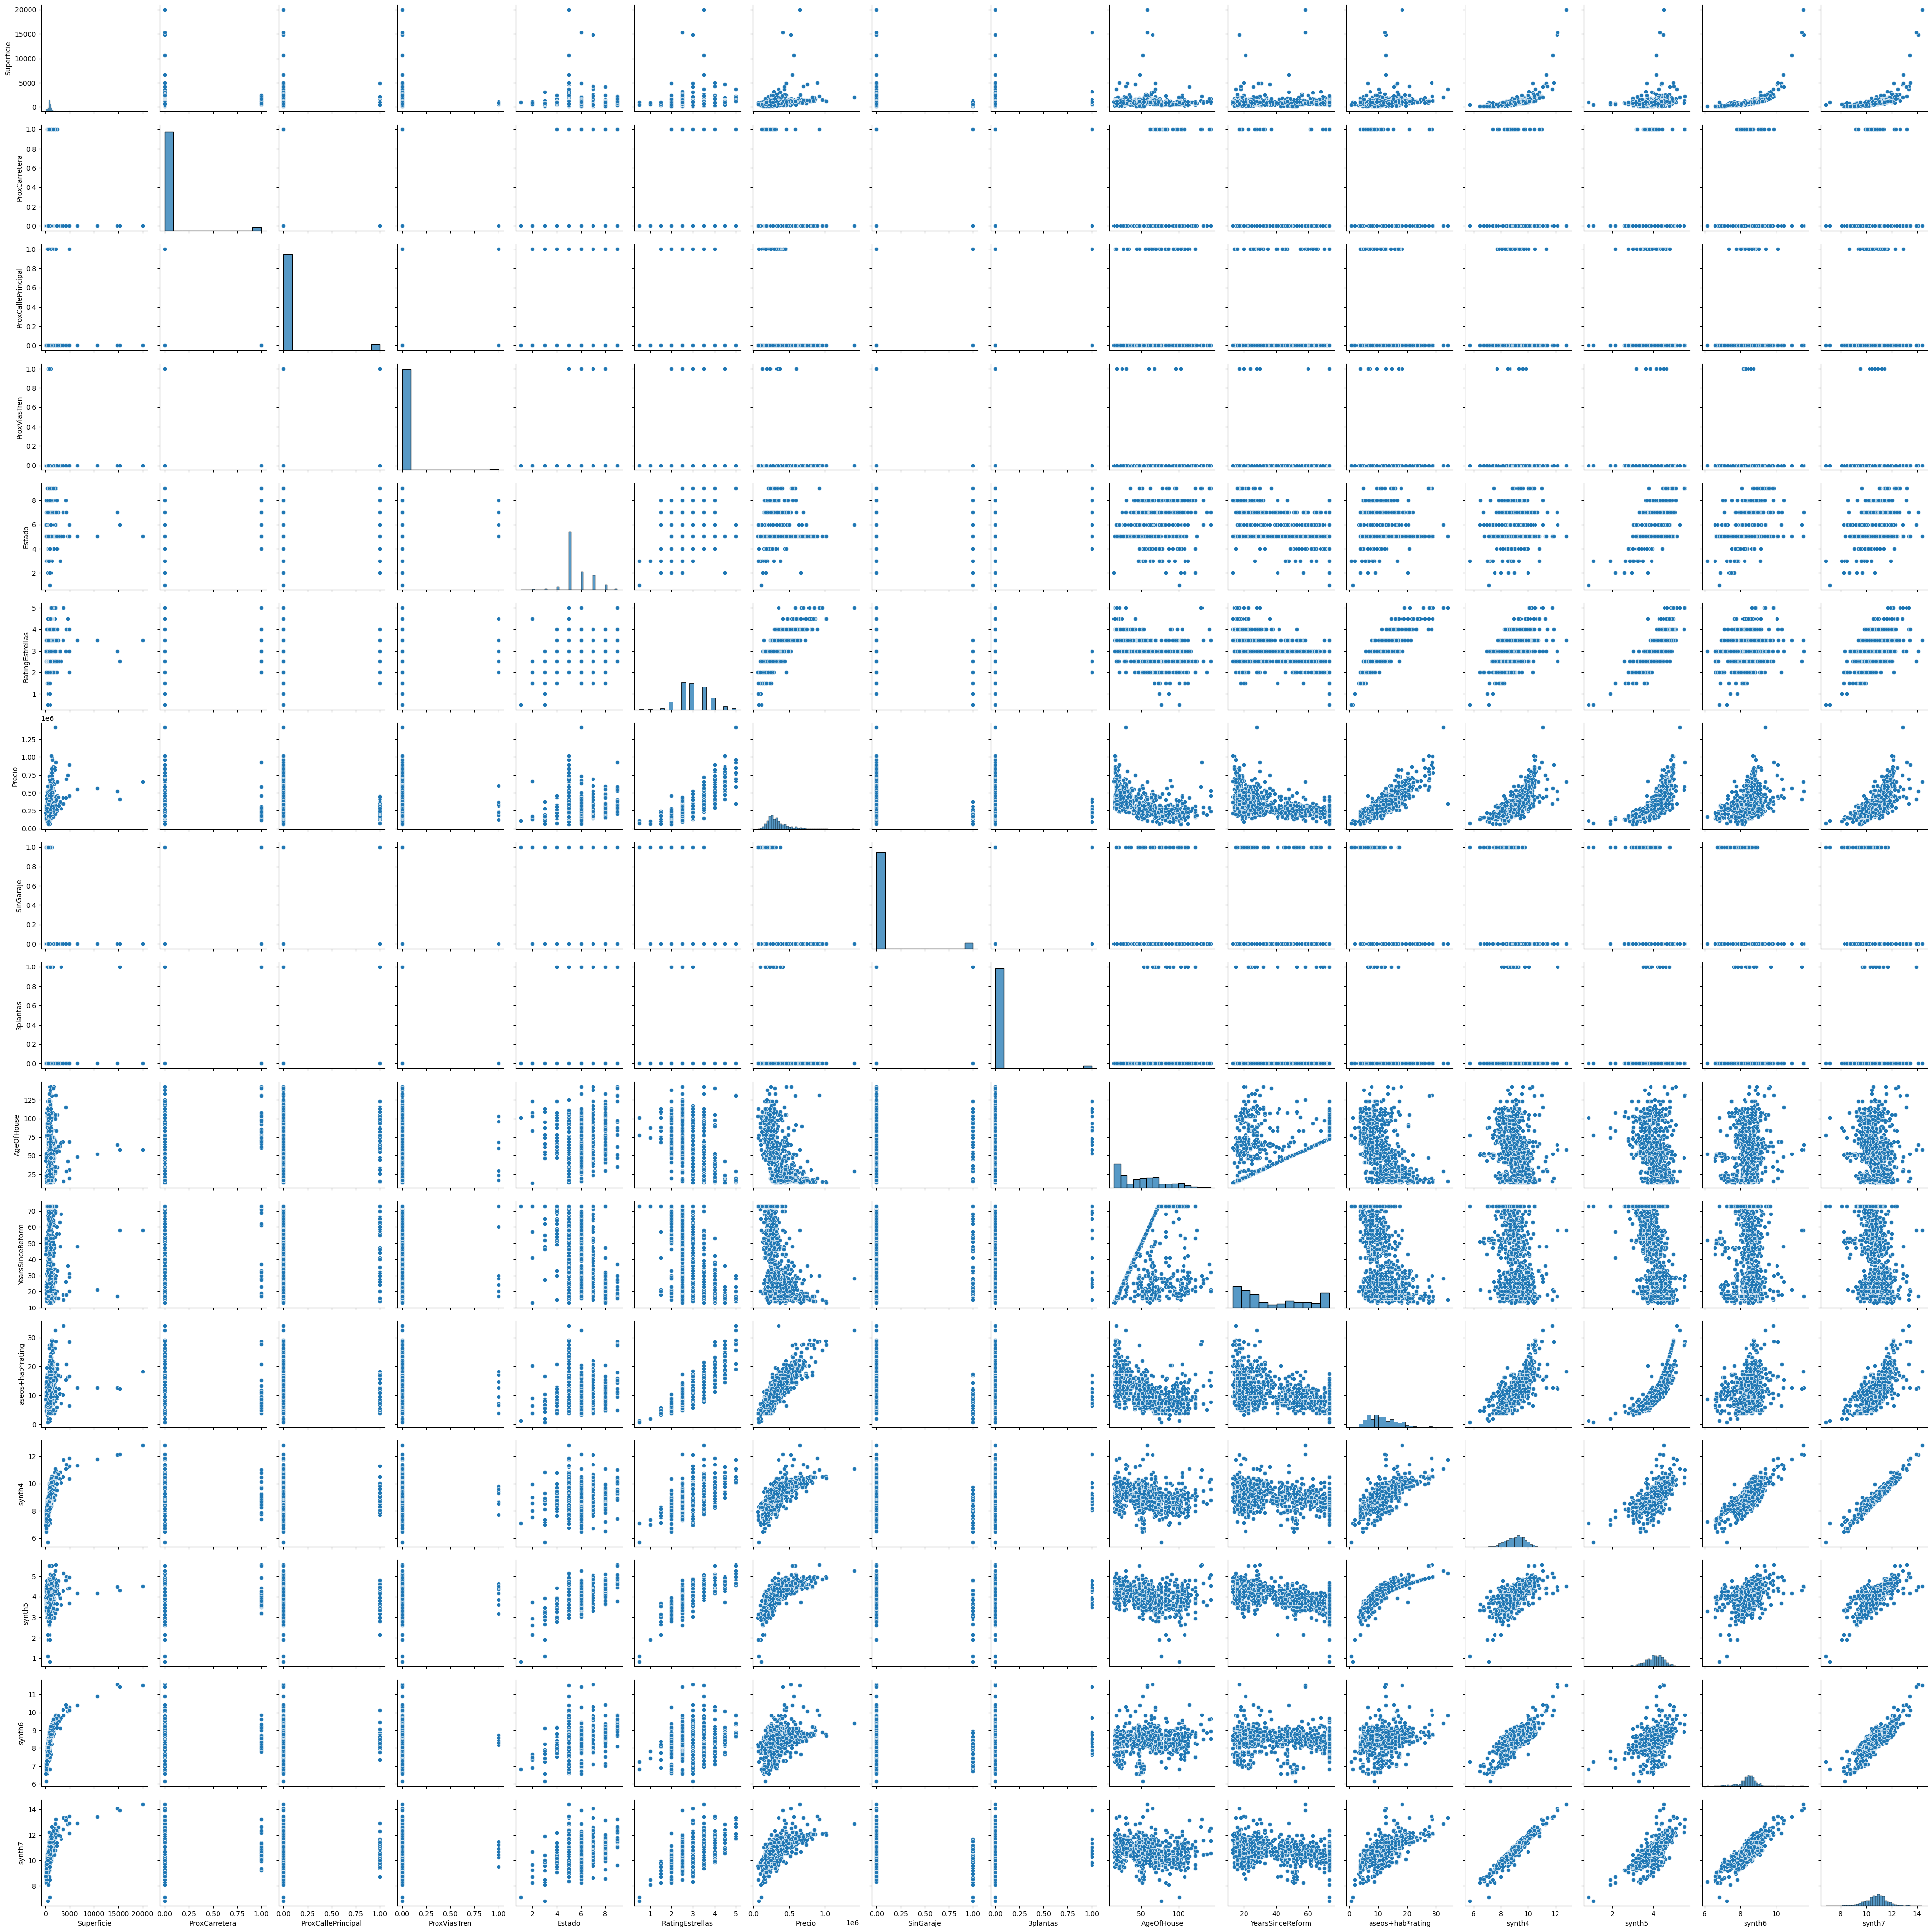

In [5]:
df.set_index('Id', inplace=True)
df.drop(['AguaCorriente', 'GasNatural', 'FosaSeptica', 'Piscina', 'Plan', 'PerimParcela'], axis=1, inplace=True)

df = extract_postal_hierarchy(df)

# df['Reformada'] = df['FechaConstruccion'] != df['FechaReforma']
# df['Reformada'] = df['Reformada'].astype(int)

# make garaje feature inverse, 0 is 1, 1 is 0
df['SinGaraje'] = df['Garaje'].apply(lambda x: 1 if x == 0 else 0)
df['3plantas'] = df['Plantas'].apply(lambda x: 1 if x == 3 else 0)

# Current Year
current_year = datetime.datetime.now().year

df['AgeOfHouse'] = current_year - df['FechaConstruccion']
df['YearsSinceReform'] = current_year - df['FechaReforma']
#df['TotalRooms'] = df['Aseos'] + df['Habitaciones']
#df['AvgProximity'] = (df['ProxCarretera'] + df['ProxCallePrincipal'] + df['ProxViasTren']) / 3

df['aseos+hab*rating'] = (0.7*df['Aseos'] + 0.3*df['Habitaciones']) * df['RatingEstrellas']
df['synth4'] = np.log1p(df['aseos+hab*rating'] * df['Superficie'])
df['synth5'] = np.log1p(df['aseos+hab*rating'] * df['Estado'])
df['synth6'] = np.log1p(df['Estado'] * df['Superficie'])
df['synth7'] = np.log1p(df['aseos+hab*rating'] * df['Superficie'] * df['Estado'])

#df['rooms/rating'] = df['Habitaciones'] / df['RatingEstrellas']

df.drop(['FechaConstruccion', 'FechaReforma', 'Garaje', 'Formato', 'TipoDesnivel', 'Desnivel', 'Situacion', 'Plantas', 'PAU', 'Vallada', 'Callejon', 'CallePavimentada', 'Aseos', 'Habitaciones'], axis=1, inplace=True)

variables_reales = df.columns[df.dtypes == 'float64']
variables_categoricas = df.dtypes[df.dtypes == 'object'].index
variables_enteras = df.columns[df.dtypes == 'int64']

#visualize_dataframe_distributions(df)
#plot_against_precio(df)
#sns.set(style="whitegrid")

sns.pairplot(df)

# Display the plots
plt.show()

#Use pairplot
# df.drop(variables_categoricas, axis=1, inplace=True)
df = one_hot_encoding(df, variables_categoricas)

df.drop(['Tipo_Chalet individual', 'CatParcela_Residencial tipo 2', 'CatParcela_Residencial unifamiliar', 'CP_50012', 'CP_50018', 'CP_60645', 'CP_61704', 'CP_62451'], axis=1, inplace=True)

#plot_against_precio(df)



# from scipy.stats import skew
# numeric_features = df.dtypes[df.dtypes != object].index
# numeric_features = numeric_features.drop('Precio')
# skewed_features = df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
# high_skew = skewed_features[skewed_features > 0.5]
# skew_index = high_skew.index

# # Normalize skewed features using log_transformation
    
# for i in skew_index:
#     df[i] = np.log1p(df[i])

# inf=pd.DataFrame(np.isinf(df).sum() ,columns=['Inf_sum'])
# inf['feat']=inf.index
# inf=inf[inf['Inf_sum']>0]
# inf=inf.sort_values(by=['Inf_sum'])
# inf.insert(0,'Serial No.',range(1,len(inf)+1))
# print(inf)

variables_enteras = variables_enteras.drop('Precio')
df = zscore_norm(df, variables_reales)
df = zscore_norm(df, variables_enteras)

#df = df[['RatingEstrellas', 'Superficie', 'Aseos', 'AgeOfHouse', 'YearsSinceReform', 'Habitaciones', 'Formato_Poco irregular', 'Situacion_Interior', 'Plantas', 'Formato_Rectangular', 'postal_group_5', 'Precio']]

df.to_csv('train_preprocessed.csv')

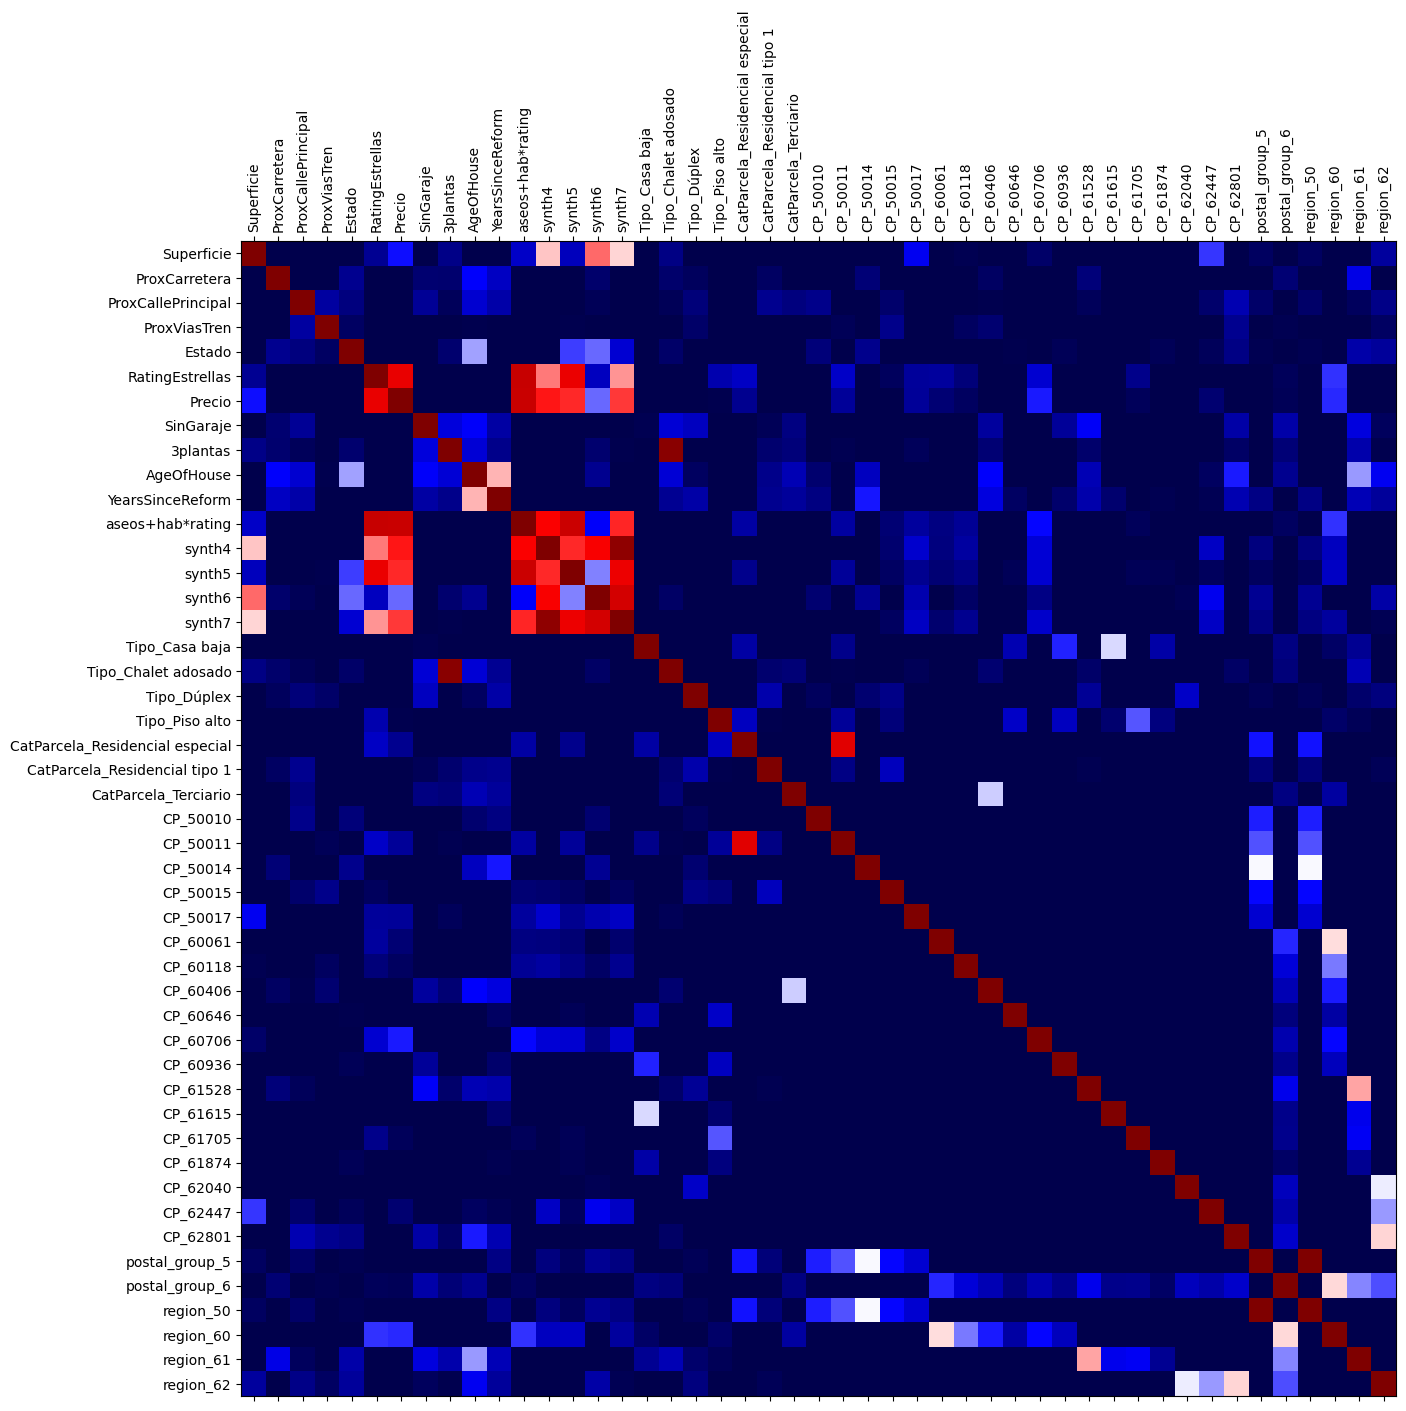

In [6]:
plot_correlation_matrix(df)

In [7]:
# corr = df.corr()
# umbral = 0.05
# # Encontrar características altamente correlacionadas
# caract_alta_correlacion = set()
# for i in range(len(corr.columns)):
#     for j in range(i):
#         if abs(corr.iloc[i, j]) < umbral:
#             colname = corr.columns[i]
#             caract_alta_correlacion.add(colname)
# caract_alta_correlacion.remove('Precio')
# # Eliminar características altamente correlacionadas
# print(caract_alta_correlacion)
# df = df.drop(caract_alta_correlacion, axis=1)
# df

### Entrenamiento

In [8]:
train_size = 0.8
train = df.sample(frac=train_size, random_state=1)
test = df.drop(train.index)

#train.reset_index(drop=True, inplace=True)

Transformaciones del input

In [9]:
train = train[train['Precio'] < 10**6]

#train = train[train['Superficie'] < 3]

#train['Superficie'] = np.log1p(train['Superficie'])

#Calculate the number of bins
# num_bins = 10
# bins = np.linspace(train['Precio'].min(), train['Precio'].max(), num_bins+1)
# mid_points = (bins[:-1] + bins[1:]) / 2

# # Bin the data
# train['binned'] = pd.cut(train['Precio'], bins=bins)
# print(train['binned'].value_counts())
# # Desired normal distribution parameters
# mean = train['Precio'].mean()
# std = train['Precio'].std()

# # Calculate the desired number of samples per bin based on normal distribution
# pdf_values = stats.norm.pdf(mid_points, mean, std)
# desired_samples_per_bin = pdf_values / sum(pdf_values) * len(train)
# print(desired_samples_per_bin)
# # ... [rest of your code remains the same up to the 'desired_samples_per_bin' calculation]

# # Get unique bin categories
# unique_bins = train['binned'].cat.categories

# # Oversample each bin
# oversampled_dfs = []

# for i, bin_category in enumerate(unique_bins):
#     bin_df = train[train['binned'] == bin_category]
#     num_samples = int(desired_samples_per_bin[i])

#     if not bin_df.empty and num_samples > 0:
#         oversampled_dfs.append(bin_df.sample(num_samples, replace=True))

# if oversampled_dfs:
#     oversampled_train = pd.concat(oversampled_dfs, axis=0).reset_index(drop=True)
#     # Drop the 'binned' column
#     oversampled_train = oversampled_train.drop(columns=['binned'])
# else:
#     print("No bins met the criteria for oversampling.")


#visualize_dataframe_distributions(oversampled_train)

#train = oversampled_train

n_iterations = 100  # number of bootstrap samples you want to create
bootstrap_samples = []

for i in range(n_iterations):
    bootstrap_sample = train.sample(n=len(train), replace=True)
    bootstrap_samples.append(bootstrap_sample)

train = pd.concat(bootstrap_samples, axis=0).reset_index(drop=True)

#visualize_dataframe_distributions(train)

train['Precio'] = np.log1p(train['Precio'])

X_train, y_train = x_y_split(train, 'Precio')
X_test, y_test = x_y_split(test, 'Precio')

MAE: 40.468685081145516
MAPE: 12.03
MAE: 39.6341134841483
MAPE: 11.5


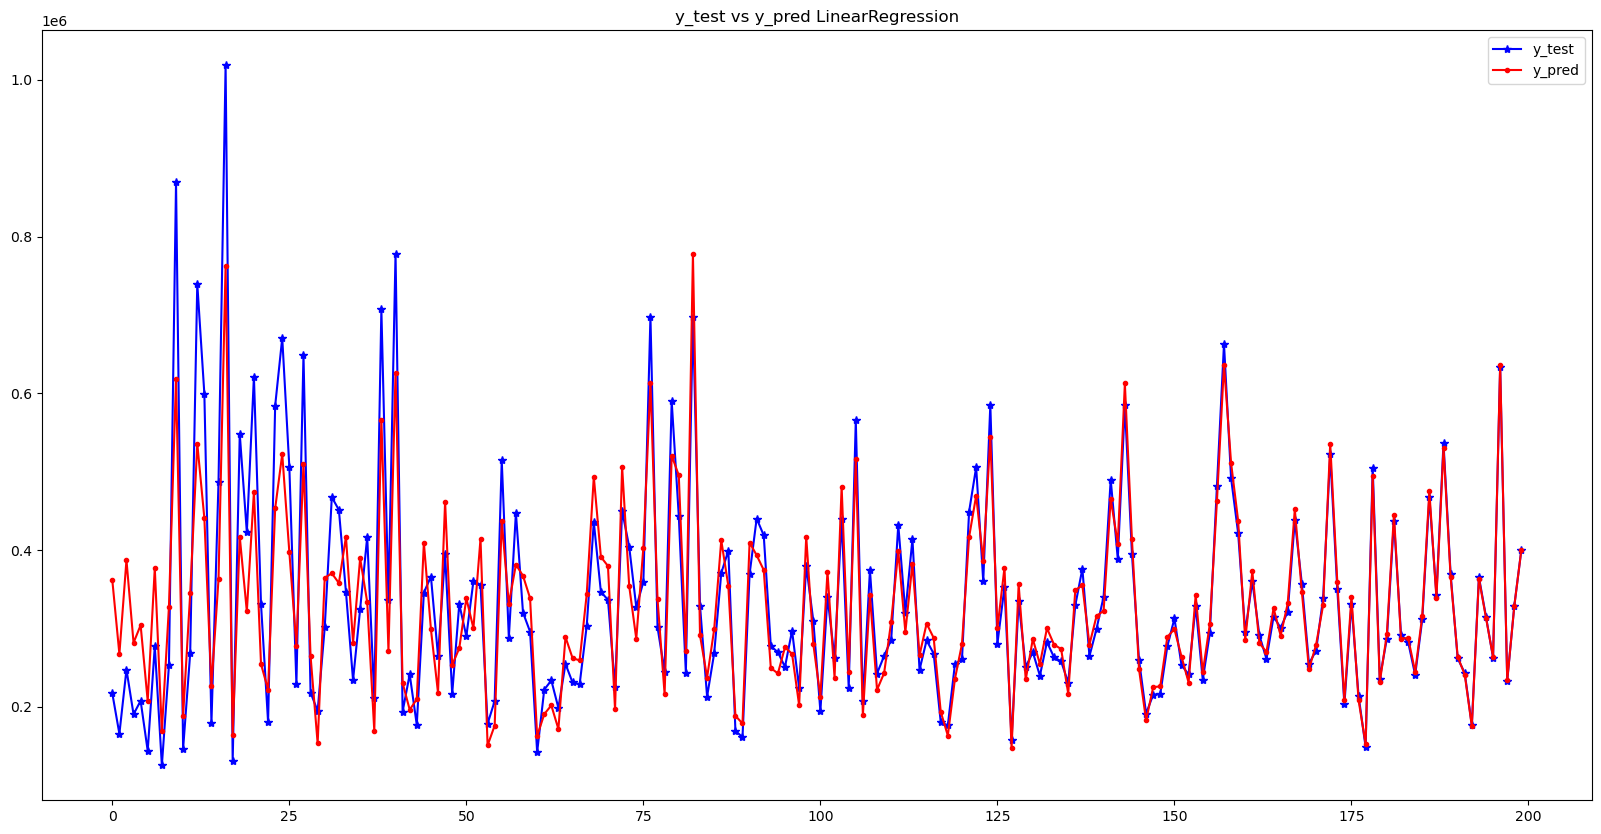

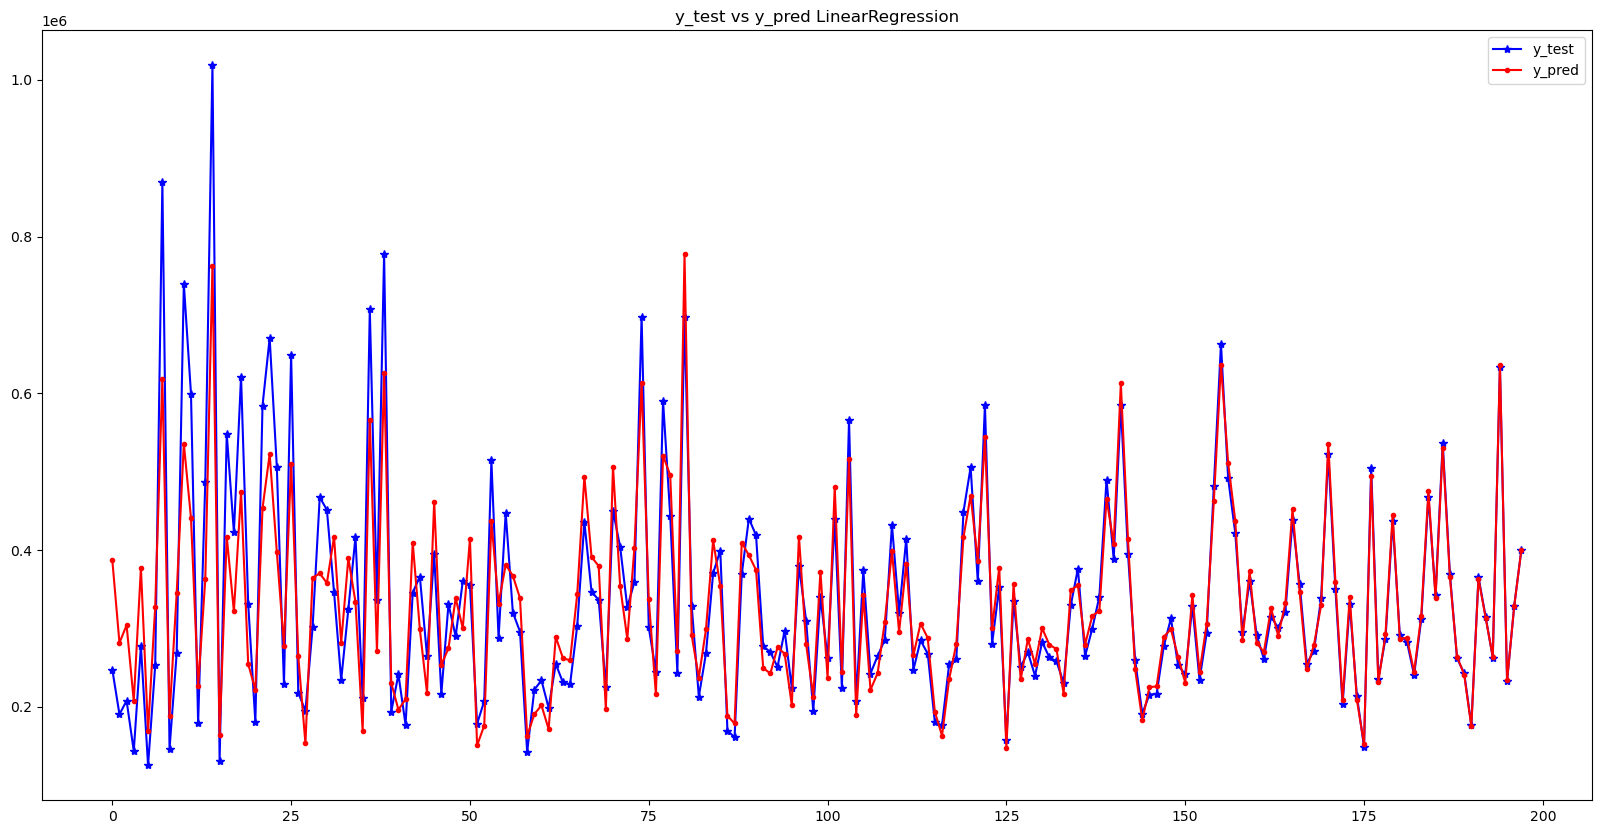

In [10]:
best_combination = {'recall': 0, 'model': None, 'norm': None, 'sampling': None, 'trained_model': None}
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

model = LinearRegression()
model_name = model.__class__.__name__
trained_model = train_model(model, X_train, y_train)
y_pred = test_model(trained_model, X_test, y_test)

y_pred = np.expm1(y_pred)

indexes = visualize_test(y_test, y_pred, ax=axes, model_name='LinearRegression')

#remove the first two indexes
indexes = indexes[2:]

y_test_2 = y_test.iloc[indexes]
y_pred_2 = y_pred[indexes]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
indexes2 = visualize_test(y_test_2, y_pred_2, ax=axes, model_name='LinearRegression')

#Get the top 10% of those indices
top_10_percent_idx = indexes[:len(indexes) // 10]

# Extract rows from X_test and y_test using these indices
X_test_top_errors = X_test.iloc[top_10_percent_idx]
y_test_top_errors = y_test.iloc[top_10_percent_idx]

#Form a DataFrame

df_top_errors = pd.concat([X_test_top_errors, y_test_top_errors], axis=1)

In [11]:
df_top_errors.head()

,Superficie,ProxCarretera,ProxCallePrincipal,ProxViasTren,Estado,RatingEstrellas,SinGaraje,3plantas,AgeOfHouse,YearsSinceReform,...,CP_62040,CP_62447,CP_62801,postal_group_5,postal_group_6,region_50,region_60,region_61,region_62,Precio
Id,,,,,,,,,,,,,,,,,,,,,
589,1.262089,-0.18464,-0.250273,-0.089758,2.176029,-0.813322,-0.243439,-0.149908,0.121068,-0.868153,...,0,1,0,0,1,0,0,0,1,247630
729,0.068678,-0.18464,-0.250273,-0.089758,-0.529353,-0.813322,-0.243439,-0.149908,0.454313,1.336400,...,0,0,0,1,0,1,0,0,0,190484
244,0.006203,-0.18464,-0.250273,-0.089758,0.372441,-0.090369,-0.243439,-0.149908,-0.278826,0.258619,...,0,0,0,1,0,1,0,0,0,207801
432,-0.447322,-0.18464,3.991642,-0.089758,1.274235,-0.090369,4.103692,-0.149908,1.720644,-0.623203,...,0,0,0,0,1,0,0,1,0,143895
349,-0.722280,-0.18464,-0.250273,-0.089758,-0.529353,0.632583,-0.243439,-0.149908,-1.045290,-0.917143,...,0,0,0,0,1,0,1,0,0,277345


MAE: 41.39691797476335
MAPE: 12.07


Id
994    143
985     81
973    115
962    197
961    146
      ... 
23     144
21      41
16     172
11      48
8      109
Name: Precio, Length: 200, dtype: int64

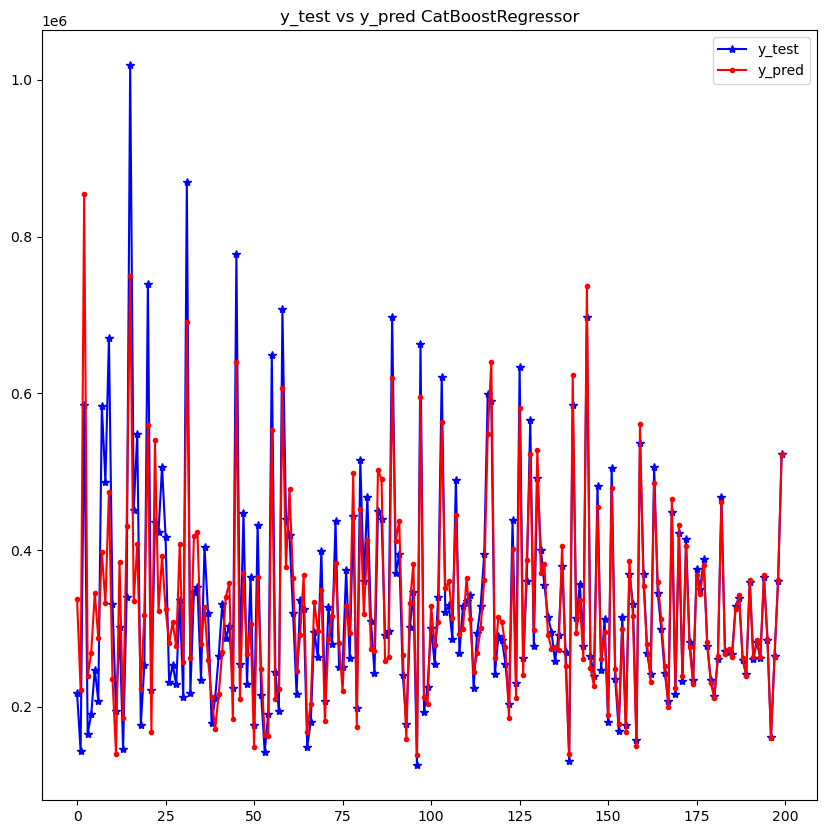

In [12]:
best_params = {'max_leaves': 8,
          'depth': 3,
          'od_wait': 200,
          'l2_leaf_reg': 3,
          'iterations': 200000,
          'model_size_reg': 0.7,
          'learning_rate': 0.05,
          'random_seed': 42 }

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
final_model = CatBoostRegressor(**best_params)

final_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

y_pred = final_model.predict(X_test)
y_pred = np.expm1(y_pred)

visualize_test(y_test, y_pred, ax=axes, model_name='CatBoostRegressor')


In [13]:
models = [LinearRegression(), RandomForestRegressor(), ElasticNet(), Lasso(), Ridge(), DecisionTreeRegressor(), KNeighborsRegressor(n_neighbors=3, weights='distance'), RandomForestRegressor(), GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000), AdaBoostRegressor()]
# cols and rows for subplots according to number of models
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models)*7))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    trained_model = train_model(model, X_train, y_train)
    y_pred = test_model(trained_model, X_test, y_test)
    y_pred = np.expm1(y_pred)

    visualize_test(y_test, y_pred, ax=axes[i], model_name=model_name)
    
plt.show()


MAE: 40.468685081145516
MAPE: 12.03
MAE: 50.387764212409245
MAPE: 14.72
MAE: 103.65719587508009
MAPE: 30.46
MAE: 103.65719587508009
MAPE: 30.46
MAE: 40.43230057655565
MAPE: 12.02
MAE: 59.81776000000151
MAPE: 17.6


In [ ]:
# grad_boost = GradientBoostingRegressor()

# distributions = {
#     'learning_rate': uniform(0.01, 0.2),
#     'n_estimators': randint(100, 1000),
#     'max_depth': randint(3, 7),
#     'min_samples_split': uniform(0.01, 0.2),
#     'min_samples_leaf': uniform(0.01, 0.1),
#     'subsample': uniform(0.8, 0.2),
#     'max_features': ['auto', 'sqrt', 'log2', None]
# }

# clf = RandomizedSearchCV(grad_boost, distributions, random_state=0, n_iter=1000, verbose=1, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
# search = clf.fit(X_train, y_train)
# search.best_params_

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
# best_model = search.best_estimator_
# y_pred = best_model.predict(X_test)
# y_pred = zscore_norm_price_inverse(y_pred)
# visualize_test(zscore_norm_price_inverse(y_test), y_pred, ax=axes, model_name=model_name)